In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from collections import Counter
sns.set()

In [2]:
iris=load_iris()

In [3]:
features=iris['data']
target=iris['target']

# Binary Search Tree warmup

In [4]:
class BST:
    def __init__(self,value):
        self.head=value
        self.right=None
        self.left=None
        
    def insert(self,value):
        if value>self.head:
            if self.right==None:
                self.right=BST(value)
            else:
                return self.right.insert(value)
        else:
            if self.left==None:
                self.left=BST(value)
            else:
                return self.left.insert(value)
    
    def read_all(self,node):
        if node is not None:
            print(node.head)
            self.read_all(node.right)
            self.read_all(node.left)
        if node is None:
            pass

# Node class

In [146]:
class Node:
    def __init__(self,cl_dic,entropy=None,feature=None,idx=None,depth=None):
        self.feature=feature # (feature_num, threshold)
        self.idx_subset=idx
        self.depth=depth
        self.entropy=entropy
        self.cl_dic=cl_dic
        self.right=None
        self.left=None
        self.prediction=None
    
    def cross_entropy(self,y,idx):
        subset=y[idx]
        z=np.zeros(len(self.cl_dic))
        for t in subset:
            k=self.cl_dic[t]
            z[k]+=1
            
        pred=z.argmax()
        z=z/z.sum()
        z=np.where(z==0,1,z)
        ent=-z*np.log2(z)
        ent=ent.sum()
        
        return pred,ent
        
    def entropy_split(self,x):
        
        z=x.copy()
        w=x.copy()
        
        w=w/w.sum(1).reshape(-1,1)
        w=np.where(w==0,1,w)
        entropy1=-w*np.log2(w)
        entropy1=entropy1.sum(1)
        
        z=z[-1]-z
        s=z.sum(1).reshape(-1,1)
        s[-1][0]=1
        z=z/s
        z=np.where(z==0,1,z)
        
        entropy2=-z*np.log2(z)
        entropy2=entropy2.sum(1)
        total=entropy1+entropy2
        j=total.argmin()
        
        return j,entropy1[j],entropy2[j]
    
    def best_feature(self,x,y,idx_subset):
        
        w=np.zeros(x.shape[1])
        indices=[]
        pos=[]
        for f in range(x.shape[1]):
            idx=np.argsort(x[:,f],axis=0)
            indices.append(idx.copy())
            y_sort=y[idx]
            z=np.zeros((x.shape[0],len(self.cl_dic)))
            cum=np.zeros(z.shape[1])
            for i,t in enumerate(y_sort):
                k=self.cl_dic[t]
                cum[k]+=1
                z[i]=cum[:]
            j,e1,e2=self.entropy_split(z)
            pos.append(j)
            w[f]=e1+e2
            
            
        num=w.argmin() #best feature index
        idx=indices[num]
        j=pos[num]
        value=x[idx][j,num]
        #multiple values for the same feature
        i=0
        while x[idx][j+i,num]==value:
            i+=1
        j=j+i-1
        
        value=x[idx][j:j+2,num].mean()
        idx_left=idx_subset[idx[:j+1]]
        idx_right=idx_subset[idx[j+1:]]
        
        pred_l,entropy_left=self.cross_entropy(y,idx[:j+1])
        pred_r,entropy_right=self.cross_entropy(y,idx[j+1:])
        j=pos[num]
        
        return num,value,pred_l,entropy_left,pred_r,entropy_right,idx_left,idx_right
    
    def split(self,node,x,y):
        if node is not None and node.entropy==0:
            pass
        if node is not None and node.feature is None:
            #split
            idx=node.idx_subset
            a,b,pl,el,pr,er,idl,idr=self.best_feature(x[idx],y[idx],idx)
            node.feature=(a,b)
            node.right=Node(entropy=er,idx=idr,depth=node.depth+1,cl_dic=node.cl_dic)
            node.right.prediction=pr #prediction
            node.left=Node(entropy=el,idx=idl,depth=node.depth+1,cl_dic=node.cl_dic)
            node.left.prediction=pl #prediction
        elif node is not None and node.feature is not None:
            #go down on tree
            self.split(node.right,x,y)
            self.split(node.left,x,y)

# Decision Tree Class

In [212]:
class DTreeClassifier:
    def __init__(self,criterion='entropy',depth=None):
        self.criterion='entropy'
        print('Using entropy criterion')
        self.max_depth=depth
        self.classes=None
        self.num_features=None
        self.head=None
        
    def fit(self,x,y):
        self.classes=sorted(list(set(y)))
        self.num_features=x.shape[1]
        cl_dic={c:i for i,c in enumerate(self.classes)}
        idx=np.arange(x.shape[0])
        
        self.head=Node(cl_dic=cl_dic,idx=idx,depth=0)
        _,self.head.entropy=self.head.cross_entropy(y,idx)
        
        for i in range(self.max_depth):
            self.head.split(self.head,x,y)
    
    #private method
    def __recurrence(self,node,x):
        if node is not None and node.feature is not None:
            f,threshold=node.feature
            if x[f]>threshold:
                return self.__recurrence(node.right,x)
            else:
                return self.__recurrence(node.left,x)
        elif node is not None and node.feature is None:
            return node.prediction
            
    def predict(self,x):
        pred=np.zeros(x.shape[0])
        for i,xi in enumerate(x):
            pred[i]=self.__recurrence(self.head,xi)
        
        return pred

In [213]:
DT=DTreeClassifier(depth=2)

Using entropy criterion


In [214]:
DT.fit(features,target)

In [209]:
features[0]

array([5.1, 3.5, 1.4, 0.2])

In [217]:
pred=DT.predict(features)

In [221]:
accuracy_score(pred,target)

0.96

# Sklearn Decision Tree Classifier

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

In [64]:
dtree=DecisionTreeClassifier()

In [65]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [66]:
dtree.max_depth=2
dtree.criterion='entropy'

In [67]:
dtree.fit(features,target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(133.92000000000002, 181.2, 'X[2] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(66.96000000000001, 108.72, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[3] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]')]

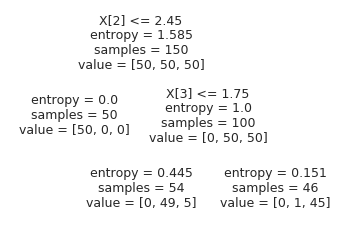

In [68]:
tree.plot_tree(dtree)